In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import psycopg2
from contextlib import contextmanager
import logging


@contextmanager
def connect(host, port, user, password, dbname):
    try:
        connection = psycopg2.connect(host=host, port=port, user=user, password=password, dbname=dbname)
        yield connection
    except Exception as e:
        connection.rollback()
        logging.error(e)
        raise
    else:
        connection.commit()
    finally:
        connection.close()


def runSQL(sql:str):
    with connect(host='127.0.0.1', port='5432', user='postgres', password='309512', dbname='data-tutorial') as conn:
        cur = conn.cursor()
        cur.execute(sql)
        cur.close()

def runSQL_result(sql:str):
    with connect(host='127.0.0.1', port='5432', user='postgres', password='309512', dbname='data-tutorial') as conn:
        cur = conn.cursor()
        cur.execute(sql)
        result = cur.fetchall()
        cur.close()
        return result

---
# country_vaccinations

In [4]:
# data source:
# https://www.kaggle.com/gpreda/covid-world-vaccination-progress


# Country - this is the country for which the vaccination information is provided;
# Country ISO Code - ISO code for the country;
# Date - date for the data entry; for some of the dates we have only the daily vaccinations, for others, only the (cumulative) total;
# Total number of vaccinations - this is the absolute number of total immunizations in the country;
# Total number of people vaccinated - a person, depending on the immunization scheme, will receive one or more (typically 2) vaccines; at a certain moment, the number of vaccination might be larger than the number of people;
# Total number of people fully vaccinated - this is the number of people that received the entire set of immunization according to the immunization scheme (typically 2); at a certain moment in time, there might be a certain number of people that received one vaccine and another number (smaller) of people that received all vaccines in the scheme;
# Daily vaccinations (raw) - for a certain data entry, the number of vaccination for that date/country;
# Daily vaccinations - for a certain data entry, the number of vaccination for that date/country;
# Total vaccinations per hundred - ratio (in percent) between vaccination number and total population up to the date in the country;
# Total number of people vaccinated per hundred - ratio (in percent) between population immunized and total population up to the date in the country;
# Total number of people fully vaccinated per hundred - ratio (in percent) between population fully immunized and total population up to the date in the country;
# Daily vaccinations per million - ratio (in ppm) between vaccination number and total population for the current date in the country;
# Vaccines used in the country - total number of vaccines used in the country (up to date);
# Source name - source of the information (national authority, international organization, local organization etc.);
# Source website - website of the source of information;

df_country_vaccinations = pd.read_csv('./country_vaccinations.csv')
display(df_country_vaccinations.dtypes)
display(df_country_vaccinations)

country                                 object
iso_code                                object
date                                    object
total_vaccinations                     float64
people_vaccinated                      float64
people_fully_vaccinated                float64
daily_vaccinations_raw                 float64
daily_vaccinations                     float64
total_vaccinations_per_hundred         float64
people_vaccinated_per_hundred          float64
people_fully_vaccinated_per_hundred    float64
daily_vaccinations_per_million         float64
vaccines                                object
source_name                             object
source_website                          object
dtype: object

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
0,Albania,ALB,2021-01-10,0.0,0.0,NaN,NaN,NaN,0.00,0.00,NaN,NaN,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/covid19-ministria-e...
1,Albania,ALB,2021-01-11,NaN,NaN,NaN,NaN,64.0,NaN,NaN,NaN,22.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/covid19-ministria-e...
2,Albania,ALB,2021-01-12,128.0,128.0,NaN,NaN,64.0,0.00,0.00,NaN,22.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/covid19-ministria-e...
3,Albania,ALB,2021-01-13,188.0,188.0,NaN,60.0,63.0,0.01,0.01,NaN,22.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/covid19-ministria-e...
4,Albania,ALB,2021-01-14,266.0,266.0,NaN,78.0,66.0,0.01,0.01,NaN,23.0,Pfizer/BioNTech,Ministry of Health,https://shendetesia.gov.al/covid19-ministria-e...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5135,Zimbabwe,ZWE,2021-02-28,18843.0,18843.0,NaN,3138.0,2551.0,0.13,0.13,NaN,172.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1367546700...
5136,Zimbabwe,ZWE,2021-03-01,21456.0,21456.0,NaN,2613.0,2877.0,0.14,0.14,NaN,194.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1367546700...
5137,Zimbabwe,ZWE,2021-03-02,25077.0,25077.0,NaN,3621.0,3005.0,0.17,0.17,NaN,202.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1367546700...
5138,Zimbabwe,ZWE,2021-03-03,27970.0,27970.0,NaN,2893.0,2871.0,0.19,0.19,NaN,193.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1367546700...


In [5]:
# create = """
#     CREATE TABLE country_vaccinations (
#         country VARCHAR(255),
#         iso_code VARCHAR(255),
#         date VARCHAR(255),
#         total_vaccinations float8,
#         people_vaccinated float8,
#         people_fully_vaccinated float8,
#         daily_vaccinations_raw float8,
#         daily_vaccinations float8,
#         total_vaccinations_per_hundred float8,
#         people_vaccinated_per_hundred float8,
#         people_fully_vaccinated_per_hundred float8,
#         daily_vaccinations_per_million float8,
#         vaccines VARCHAR(255),
#         source_name VARCHAR(255),
#         source_website TEXT
#     )
#     """
# runSQL_result(create)


# # run once, copy csv to db
# with connect(host='127.0.0.1', port='5432', user='postgres', password='309512', dbname='data-tutorial') as conn:
#     cur = conn.cursor()
#     f = open('./country_vaccinations.csv', 'r')
#     copy_sql = """
#         COPY country_vaccinations FROM stdin WITH CSV HEADER
#         DELIMITER as ','
#         """
#     cur.copy_expert(sql=copy_sql, file=f)
#     f.close()
#     cur.close()

# print(runSQL('DELETE FROM country_vaccinations'))
print(runSQL_result('SELECT COUNT(*) FROM country_vaccinations'))
print(runSQL_result('SELECT * FROM country_vaccinations LIMIT 1'))

[(5140,)]
[('Albania', 'ALB', '2021-01-10', 0.0, 0.0, None, None, None, 0.0, 0.0, None, None, 'Pfizer/BioNTech', 'Ministry of Health', 'https://shendetesia.gov.al/covid19-ministria-e-shendetesise-766-te-vaksinuar-3149-testime-903-te-sheruar-851-raste-te-reja-dhe-21-humbje-jete-ne-24-oret-e-fundit/')]


In [6]:
# group by country and only keep rows on the most recent date (since they are .max())
df_country_vaccinations_grouped = df_country_vaccinations.groupby(["country",'iso_code','vaccines']).max().reset_index()
# df_country_vaccinations_grouped.to_csv('./df_country_vaccinations_grouped.csv', index=False)
display(df_country_vaccinations_grouped.describe())

,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million
count,1.190000e+02,1.010000e+02,6.400000e+01,8.400000e+01,1.170000e+02,119.000000,101.000000,64.000000,117.000000
mean,2.383004e+06,1.647196e+06,9.527630e+05,1.250616e+05,7.590320e+04,10.167311,8.194455,4.715469,3794.025641
std,9.324418e+06,5.993444e+06,3.507355e+06,3.245437e+05,2.706524e+05,18.236740,13.019551,8.318153,6946.463720
min,1.070000e+02,1.570000e+02,6.550000e+02,3.000000e+01,3.100000e+01,0.000000,0.000000,0.010000,1.000000
25%,1.801250e+04,1.600000e+04,2.167400e+04,3.823250e+03,1.204000e+03,0.310000,0.310000,1.052500,376.000000
50%,8.685400e+04,1.000000e+05,1.856365e+05,1.927450e+04,6.176000e+03,4.100000,4.430000,2.615000,1847.000000
75%,8.292055e+05,6.557190e+05,5.703512e+05,7.853275e+04,2.725900e+04,9.745000,7.760000,3.382500,3450.000000
max,8.257285e+07,5.403567e+07,2.779598e+07,2.429823e+06,2.042676e+06,120.660000,76.070000,44.590000,54264.000000


Pfizer/BioNTech                                                                       25
Moderna, Oxford/AstraZeneca, Pfizer/BioNTech                                          20
Oxford/AstraZeneca                                                                    18
Sputnik V                                                                             10
Oxford/AstraZeneca, Pfizer/BioNTech                                                    7
Sinovac                                                                                7
Moderna, Pfizer/BioNTech                                                               7
Sinopharm/Beijing                                                                      6
Pfizer/BioNTech, Sinovac                                                               3
Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm/Beijing, Sputnik V                      2
Oxford/AstraZeneca, Sinopharm/Beijing                                                  2
Johnson&Johnson      

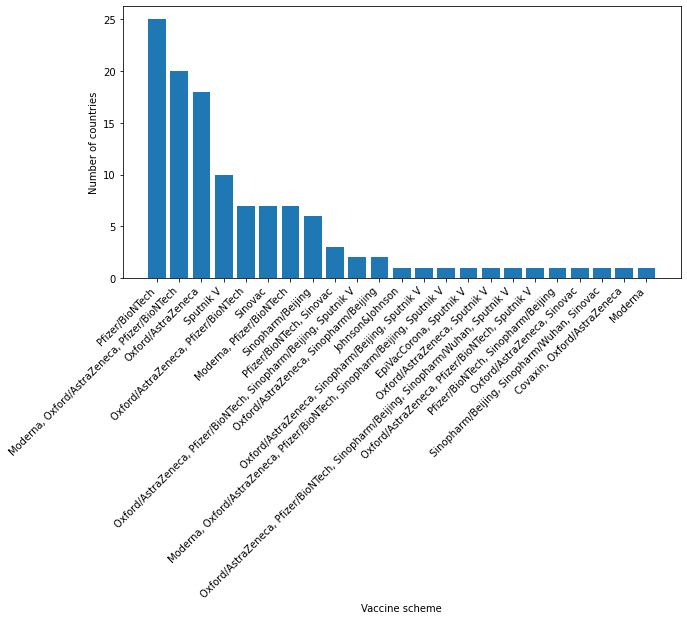

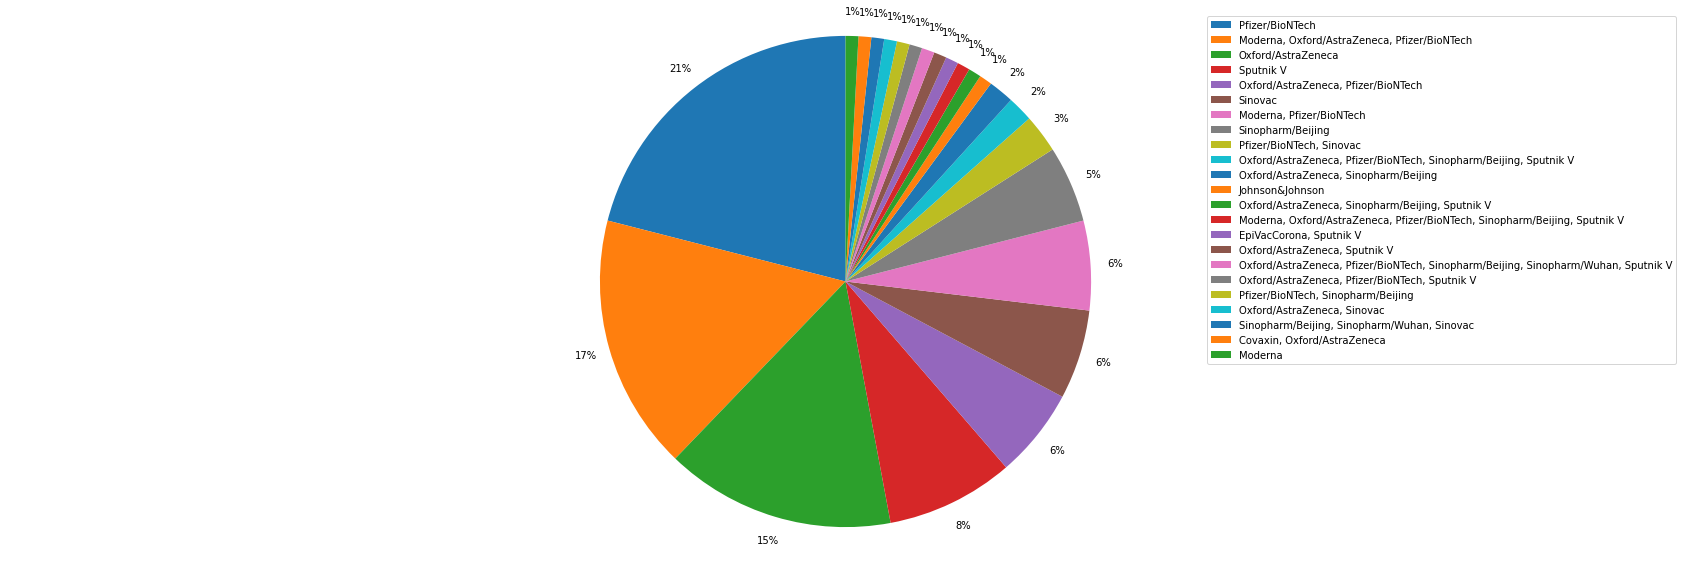

In [7]:
# rank vaccine scheme counts
current_info = df_country_vaccinations_grouped['vaccines'].value_counts()
print(current_info)

fig,ax = plt.subplots(figsize=(10, 5))
plt.bar(current_info.keys().tolist(), current_info.values)
# plt.xticks(rotation=45)
ax.set_xticklabels(current_info.keys().tolist(), rotation=45, ha='right')
plt.xlabel('Vaccine scheme')
plt.ylabel('Number of countries')
plt.show()

fig1, ax1 = plt.subplots(figsize=(30, 10))
patches, texts, autotexts = ax1.pie(current_info.values, startangle=90, autopct='%1.0f%%', pctdistance=1.1)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.legend(patches, current_info.keys().tolist(), loc="best")
plt.show()

                  country  total_vaccinations
115         United States          82572848.0
21                  China          52520000.0
114        United Kingdom          21946433.0
48                  India          18005503.0
15                 Brazil           9739676.0
110                Turkey           9560038.0
53                 Israel           8555933.0
37                Germany           6813173.0
113  United Arab Emirates           6204004.0
92                 Russia           6010744.0
36                 France           5016763.0
54                  Italy           4944619.0
20                  Chile           4270024.0
75                Morocco           4233129.0
104                 Spain           4229092.0
88                 Poland           3619316.0
9              Bangladesh           3581169.0
49              Indonesia           3386351.0
70                 Mexico           2676035.0
18                 Canada           2169417.0
91                Romania         

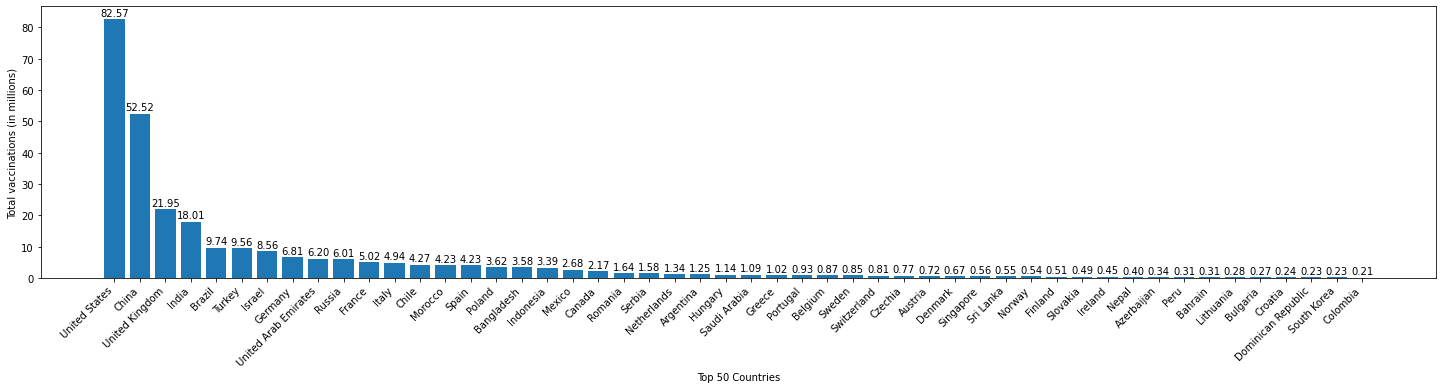

In [8]:
# rank total_vaccinations by country
current_info = df_country_vaccinations_grouped[['country','total_vaccinations']].nlargest(50,'total_vaccinations')
print(current_info)

from matplotlib.ticker import FuncFormatter

fig,ax = plt.subplots(figsize=(25, 5))
rect = plt.bar(current_info['country'], current_info['total_vaccinations'])
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{0:g}'.format(x/1000000))) # show y tick in millions
ax.set_xticklabels(current_info['country'], rotation=45, ha='right')
for i, v in enumerate(current_info['total_vaccinations']):
    ax.text(i, v + 1000000, "{:.2f}".format(v/1000000), ha='center')
    # ax.text(rect.get_x() + rect.get_width()/2., 1.05*rect.get_height(), '%d' % int(rect.get_height()), ha='center', va='bottom')
plt.xlabel('Top 50 Countries')
plt.ylabel('Total vaccinations (in millions)')
plt.show()


# Observations:
# when not considering population, only from absolute total_vaccinations values,
# Tier 1: US, China, UK, India
# Tier 2: Brazil, Turkey, Isreal

# Tier 3: other countries (mostly Europe countries)

In [9]:
# calculate p-value

from scipy.stats import pearsonr, kendalltau, spearmanr

def p_val_pearsonr(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

def p_val_kendalltau(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(kendalltau(df[r], df[c])[1], 4)
    return pvalues

def p_val_spearmanr(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(spearmanr(df[r], df[c])[1], 4)
    return pvalues

---
# country_gdp

In [10]:
# data source:
# https://data.worldbank.org/indicator/NY.GDP.MKTP.CD


# take GDP data from all countries from 2010-2019 as country_gdp_simple.csv
df_country_gdp = pd.read_csv('./country_gdp.csv')
df_country_gdp.drop(columns=['Indicator Name', 'Indicator Code'], inplace=True) # drop these since all the same, not used in this analysis
df_country_gdp.drop(columns=[str(i) for i in range(1960, 2010)], inplace=True) # drop data from 1960-2009
df_country_gdp.drop(columns=df_country_gdp.columns[-2:], inplace=True) # drop empty 2020 column and empty last unnamed column
display(df_country_gdp.dtypes)
display(df_country_gdp)
# df_country_gdp.to_csv('./country_gdp_simple.csv', index=False)

Country Name     object
Country Code     object
2010            float64
2011            float64
2012            float64
2013            float64
2014            float64
2015            float64
2016            float64
2017            float64
2018            float64
2019            float64
dtype: object

,Country Name,Country Code,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Aruba,ABW,2.390503e+09,2.549721e+09,2.534637e+09,2.701676e+09,2.765363e+09,2.919553e+09,2.965922e+09,3.056425e+09,NaN,NaN
1,Afghanistan,AFG,1.585657e+10,1.780429e+10,2.000160e+10,2.056107e+10,2.048489e+10,1.990711e+10,1.801775e+10,1.886995e+10,1.835388e+10,1.929110e+10
2,Angola,AGO,8.379950e+10,1.117897e+11,1.280529e+11,1.367099e+11,1.457122e+11,1.161936e+11,1.011239e+11,1.221238e+11,1.013532e+11,8.881570e+10
3,Albania,ALB,1.192693e+10,1.289077e+10,1.231983e+10,1.277622e+10,1.322814e+10,1.138685e+10,1.186120e+10,1.301969e+10,1.514702e+10,1.527918e+10
4,Andorra,AND,3.449967e+09,3.629204e+09,3.188809e+09,3.193704e+09,3.271808e+09,2.789870e+09,2.896679e+09,3.000181e+09,3.218316e+09,3.154058e+09
...,...,...,...,...,...,...,...,...,...,...,...,...
259,Kosovo,XKX,5.835874e+09,6.701698e+09,6.499807e+09,7.074778e+09,7.396705e+09,6.442916e+09,6.719172e+09,7.245707e+09,7.942962e+09,7.926134e+09
260,"Yemen, Rep.",YEM,3.090675e+10,3.272642e+10,3.540134e+10,4.041524e+10,4.320647e+10,4.245062e+10,3.093598e+10,2.673614e+10,2.348627e+10,2.258108e+10
261,South Africa,ZAF,3.753494e+11,4.164189e+11,3.963327e+11,3.668294e+11,3.509046e+11,3.176205e+11,2.963573e+11,3.495541e+11,3.682889e+11,3.514316e+11
262,Zambia,ZMB,2.026556e+10,2.345952e+10,2.550306e+10,2.804555e+10,2.715073e+10,2.124334e+10,2.095475e+10,2.586817e+10,2.631214e+10,2.330977e+10


In [11]:
# create = """
#     CREATE TABLE country_gdp_simple (
#         country VARCHAR(255),
#         iso_code VARCHAR(255),
#         _2010 float8,
#         _2011 float8,
#         _2012 float8,
#         _2013 float8,
#         _2014 float8,
#         _2015 float8,
#         _2016 float8,
#         _2017 float8,
#         _2018 float8,
#         _2019 float8
#     )
#     """
# runSQL(create)


# # run once, copy csv to db
# with connect(host='127.0.0.1', port='5432', user='postgres', password='309512', dbname='data-tutorial') as conn:
#     cur = conn.cursor()
#     f = open('./country_gdp_simple.csv', 'r')
#     copy_sql = """
#         COPY country_gdp_simple FROM stdin WITH CSV HEADER
#         DELIMITER as ','
#         """
#     cur.copy_expert(sql=copy_sql, file=f)
#     f.close()
#     cur.close()

# print(runSQL('DELETE FROM country_gdp_simple'))
print(runSQL_result('SELECT COUNT(*) FROM country_gdp_simple'))
print(runSQL_result('SELECT * FROM country_gdp_simple LIMIT 1'))

[(264,)]
[('Aruba', 'ABW', 2390502793.2960896, 2549720670.3910604, 2534636871.50838, 2701675977.6536303, 2765363128.49162, 2919553072.6257, 2965921787.7095, 3056424581.00559, None, None)]


In [12]:
# find correlation between total_vaccinations and 2019 DGP
left = df_country_vaccinations_grouped[['iso_code', 'total_vaccinations', 'total_vaccinations_per_hundred']]
right = df_country_gdp[['Country Code', '2019']]
right.columns = ['iso_code', 'GDP_2019'] # rename columns
df_correlation_data = pd.merge(left, right, on='iso_code') # INNER JOIN ON iso_code

df_correlation_data_all = pd.merge(left, right, on='iso_code')

df_correlation_data = df_correlation_data.dropna()
display(df_correlation_data)
# df_correlation_data.to_csv('./df_correlation_data.csv', index=False)

df_correlation_data.drop(columns=['iso_code'], inplace=True) # drop iso_code since not used in correlation

correlation_matrix = df_correlation_data.corr(method='pearson')
display(correlation_matrix.style.background_gradient(cmap='coolwarm'))
display(p_val_pearsonr(df_correlation_data))

correlation_matrix = df_correlation_data.corr(method='kendall')
display(correlation_matrix.style.background_gradient(cmap='coolwarm'))
display(p_val_kendalltau(df_correlation_data))

correlation_matrix = df_correlation_data.corr(method='spearman')
display(correlation_matrix.style.background_gradient(cmap='coolwarm'))
display(p_val_spearmanr(df_correlation_data))

,iso_code,total_vaccinations,total_vaccinations_per_hundred,GDP_2019
0,ALB,15793.0,0.55,1.527918e+10
1,DZA,75000.0,0.17,1.710913e+11
2,AND,2526.0,3.27,3.154058e+09
3,ARG,1252461.0,2.77,4.454452e+11
4,AUS,61008.0,0.24,1.396567e+12
...,...,...,...,...
106,ARE,6204004.0,62.73,4.211423e+11
107,GBR,21946433.0,32.33,2.829108e+12
108,USA,82572848.0,24.69,2.143323e+13
109,URY,54154.0,1.56,5.604591e+10


,total_vaccinations,total_vaccinations_per_hundred,GDP_2019
total_vaccinations,1.000000,0.176593,0.954149
total_vaccinations_per_hundred,0.176593,1.000000,0.067875
GDP_2019,0.954149,0.067875,1.000000


,total_vaccinations,total_vaccinations_per_hundred,GDP_2019
total_vaccinations,0,0.0758,0
total_vaccinations_per_hundred,0.0758,0,0.4979
GDP_2019,0,0.4979,0


,total_vaccinations,total_vaccinations_per_hundred,GDP_2019
total_vaccinations,1.000000,0.444100,0.504950
total_vaccinations_per_hundred,0.444100,1.000000,0.052545
GDP_2019,0.504950,0.052545,1.000000


,total_vaccinations,total_vaccinations_per_hundred,GDP_2019
total_vaccinations,0,0,0
total_vaccinations_per_hundred,0,0,0.4349
GDP_2019,0,0.4349,0


,total_vaccinations,total_vaccinations_per_hundred,GDP_2019
total_vaccinations,1.000000,0.619179,0.671871
total_vaccinations_per_hundred,0.619179,1.000000,0.079760
GDP_2019,0.671871,0.079760,1.000000


,total_vaccinations,total_vaccinations_per_hundred,GDP_2019
total_vaccinations,0,0,0
total_vaccinations_per_hundred,0,0,0.4255
GDP_2019,0,0.4255,0


---
# country_gdppc

In [13]:
# data source:
# https://data.worldbank.org/indicator/NY.GDP.PCAP.CD


# take GDPpc data from all countries from 2010-2019 as country_gdppc_simple.csv
df_country_gdppc = pd.read_csv('./country_gdppc.csv')
df_country_gdppc.drop(columns=['Indicator Name', 'Indicator Code'], inplace=True) # drop these since all the same, not used in this analysis
df_country_gdppc.drop(columns=[str(i) for i in range(1960, 2010)], inplace=True) # drop data from 1960-2009
df_country_gdppc.drop(columns=df_country_gdppc.columns[-2:], inplace=True) # drop empty 2020 column and empty last unnamed column
display(df_country_gdppc.dtypes)
display(df_country_gdppc)
# df_country_gdppc.to_csv('./country_gdppc_simple.csv', index=False)

Country Name     object
Country Code     object
2010            float64
2011            float64
2012            float64
2013            float64
2014            float64
2015            float64
2016            float64
2017            float64
2018            float64
2019            float64
dtype: object

,Country Name,Country Code,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Aruba,ABW,23512.602596,24985.993281,24713.698045,26189.435509,26647.938101,27980.880695,28281.350482,29007.693003,NaN,NaN
1,Afghanistan,AFG,543.303042,591.162759,641.871479,637.165523,613.856689,578.466353,509.218661,519.884773,493.750418,507.103432
2,Angola,AGO,3587.883798,4615.468028,5100.095808,5254.882338,5408.410496,4166.979684,3506.072885,4095.812942,3289.646664,2790.726615
3,Albania,ALB,4094.350334,4437.142885,4247.629984,4413.060861,4578.631994,3952.801215,4124.055726,4531.020806,5284.380184,5353.244856
4,Andorra,AND,40852.666777,43335.328862,38686.461264,39538.766722,41303.929371,35762.523074,37474.665406,38962.880354,41793.055258,40886.391165
...,...,...,...,...,...,...,...,...,...,...,...,...
259,Kosovo,XKX,3286.557443,3741.875052,3596.804655,3891.266363,4080.330717,3603.025501,3780.003689,4045.614209,4419.914327,4417.524062
260,"Yemen, Rep.",YEM,1334.784845,1374.621285,1446.536354,1607.152365,1673.146354,1602.037841,1138.682995,960.528534,824.117629,774.334490
261,South Africa,ZAF,7328.615629,8007.412846,7501.469984,6832.456891,6433.187277,5734.633629,5272.918425,6132.479841,6374.028196,6001.400814
262,Zambia,ZMB,1489.459306,1672.908251,1763.072733,1878.909697,1763.062571,1337.795586,1280.578447,1534.866751,1516.390661,1305.063254


In [14]:
# create = """
#     CREATE TABLE country_gdppc_simple (
#         country VARCHAR(255),
#         iso_code VARCHAR(255),
#         _2010 float8,
#         _2011 float8,
#         _2012 float8,
#         _2013 float8,
#         _2014 float8,
#         _2015 float8,
#         _2016 float8,
#         _2017 float8,
#         _2018 float8,
#         _2019 float8
#     )
#     """
# runSQL_result(create)


# # run once, copy csv to db
# with connect(host='127.0.0.1', port='5432', user='postgres', password='309512', dbname='data-tutorial') as conn:
#     cur = conn.cursor()
#     f = open('./country_gdppc_simple.csv', 'r')
#     copy_sql = """
#         COPY country_gdppc_simple FROM stdin WITH CSV HEADER
#         DELIMITER as ','
#         """
#     cur.copy_expert(sql=copy_sql, file=f)
#     f.close()
#     cur.close()

# print(runSQL('DELETE FROM country_gdppc_simple'))
print(runSQL_result('SELECT COUNT(*) FROM country_gdppc_simple'))
print(runSQL_result('SELECT * FROM country_gdppc_simple LIMIT 1'))

[(264,)]
[('Aruba', 'ABW', 23512.602595639702, 24985.9932813737, 24713.6980451285, 26189.4355088129, 26647.938100985, 27980.880695275097, 28281.35048163, 29007.6930034887, None, None)]


In [15]:
# find correlation between total_vaccinations and 2019 DGPpc
left = df_country_vaccinations_grouped[['iso_code', 'total_vaccinations', 'total_vaccinations_per_hundred']]
right = df_country_gdppc[['Country Code', '2019']]
right.columns = ['iso_code', 'GDPpc_2019'] # rename columns
df_correlation_data = pd.merge(left, right, on='iso_code') # INNER JOIN ON iso_code

df_correlation_data_all = pd.merge(df_correlation_data_all, right, on='iso_code')

df_correlation_data = df_correlation_data.dropna()
display(df_correlation_data)
# df_correlation_data.to_csv('./df_correlation_data.csv', index=False)

df_correlation_data.drop(columns=['iso_code'], inplace=True) # drop iso_code since not used in correlation

correlation_matrix = df_correlation_data.corr(method='pearson')
display(correlation_matrix.style.background_gradient(cmap='coolwarm'))
display(p_val_pearsonr(df_correlation_data))

correlation_matrix = df_correlation_data.corr(method='kendall')
display(correlation_matrix.style.background_gradient(cmap='coolwarm'))
display(p_val_kendalltau(df_correlation_data))

correlation_matrix = df_correlation_data.corr(method='spearman')
display(correlation_matrix.style.background_gradient(cmap='coolwarm'))
display(p_val_spearmanr(df_correlation_data))

,iso_code,total_vaccinations,total_vaccinations_per_hundred,GDPpc_2019
0,ALB,15793.0,0.55,5353.244856
1,DZA,75000.0,0.17,3973.964072
2,AND,2526.0,3.27,40886.391165
3,ARG,1252461.0,2.77,9912.281809
4,AUS,61008.0,0.24,55060.326101
...,...,...,...,...
106,ARE,6204004.0,62.73,43103.323058
107,GBR,21946433.0,32.33,42330.117537
108,USA,82572848.0,24.69,65297.517508
109,URY,54154.0,1.56,16190.126957


,total_vaccinations,total_vaccinations_per_hundred,GDPpc_2019
total_vaccinations,1.000000,0.176593,0.103597
total_vaccinations_per_hundred,0.176593,1.000000,0.266324
GDPpc_2019,0.103597,0.266324,1.000000


,total_vaccinations,total_vaccinations_per_hundred,GDPpc_2019
total_vaccinations,0,0.0758,0.3001
total_vaccinations_per_hundred,0.0758,0,0.0068
GDPpc_2019,0.3001,0.0068,0


,total_vaccinations,total_vaccinations_per_hundred,GDPpc_2019
total_vaccinations,1.000000,0.444100,0.149291
total_vaccinations_per_hundred,0.444100,1.000000,0.412962
GDPpc_2019,0.149291,0.412962,1.000000


,total_vaccinations,total_vaccinations_per_hundred,GDPpc_2019
total_vaccinations,0,0,0.0262
total_vaccinations_per_hundred,0,0,0
GDPpc_2019,0.0262,0,0


,total_vaccinations,total_vaccinations_per_hundred,GDPpc_2019
total_vaccinations,1.000000,0.619179,0.237494
total_vaccinations_per_hundred,0.619179,1.000000,0.587668
GDPpc_2019,0.237494,0.587668,1.000000


,total_vaccinations,total_vaccinations_per_hundred,GDPpc_2019
total_vaccinations,0,0,0.0162
total_vaccinations_per_hundred,0,0,0
GDPpc_2019,0.0162,0,0


---
# human-development-index

In [16]:
# data source
# df_hdi_2019: http://hdr.undp.org/en/data
# df_hdi_2017: https://ourworldindata.org/human-development-index

# df_hdi_2017 has iso_code, but df_hdi_2019 does not
# cannot join
# TODO: use data in 2019 with iso_code

df_hdi_2017 = pd.read_csv('./human-development-index.csv')
print(df_hdi_2017.dtypes, '\n')
# print(df_hdi_2017)

df_hdi_2019 = pd.read_csv('./Human Development Index (HDI).csv')
print(df_hdi_2019.dtypes, '\n')
# print(df_hdi_2019)


df_hdi_2017 = df_hdi_2017[df_hdi_2017['Year'] == 2017]
# len = 190
print(df_hdi_2017, '\n')
# len = 189
print(df_hdi_2019['2019'].iloc[:189], '\n')
# some country names for the same country not written in the same way
# len not equal, cannot proceed


df_hdi_2017.to_csv('./df_hdi_2017.csv', index=False)
# manually add column hdi_2019 using Excel
# change file name to df_hdi_2019_with_iso_code.csv
df_hdi_2019_with_iso_code = pd.read_csv('./df_hdi_2019_with_iso_code.csv')
print(df_hdi_2019_with_iso_code, '\n')

Entity                             object
Code                               object
Year                                int64
Human Development Index (UNDP)    float64
dtype: object 

HDI Rank        object
Country         object
1990            object
Unnamed: 3     float64
1991            object
                ...   
Unnamed: 57    float64
2018            object
Unnamed: 59    float64
2019            object
Unnamed: 61    float64
Length: 62, dtype: object 

           Entity Code  Year  Human Development Index (UNDP)
17    Afghanistan  AFG  2017                           0.498
47        Albania  ALB  2017                           0.785
75        Algeria  DZA  2017                           0.754
93        Andorra  AND  2017                           0.858
112        Angola  AGO  2017                           0.581
...           ...  ...   ...                             ...
4882    Venezuela  VEN  2017                           0.761
4912      Vietnam  VNM  2017                   

In [17]:
# find correlation
left = df_country_vaccinations_grouped[['iso_code', 'total_vaccinations', 'total_vaccinations_per_hundred']]
right = df_hdi_2019_with_iso_code[['Code', 'hdi_2019']]
right.columns = ['iso_code', 'hdi_2019'] # rename columns
df_correlation_data = pd.merge(left, right, on='iso_code') # INNER JOIN ON iso_code

df_correlation_data_all = pd.merge(df_correlation_data_all, right, on='iso_code')

df_correlation_data = df_correlation_data.dropna()
display(df_correlation_data)
# df_correlation_data.to_csv('./df_correlation_data.csv', index=False)

df_correlation_data.drop(columns=['iso_code'], inplace=True) # drop iso_code since not used in correlation

correlation_matrix = df_correlation_data.corr(method='pearson')
display(correlation_matrix.style.background_gradient(cmap='coolwarm'))
display(p_val_pearsonr(df_correlation_data))

correlation_matrix = df_correlation_data.corr(method='kendall')
display(correlation_matrix.style.background_gradient(cmap='coolwarm'))
display(p_val_kendalltau(df_correlation_data))

correlation_matrix = df_correlation_data.corr(method='spearman')
display(correlation_matrix.style.background_gradient(cmap='coolwarm'))
display(p_val_spearmanr(df_correlation_data))

,iso_code,total_vaccinations,total_vaccinations_per_hundred,hdi_2019
0,ALB,15793.0,0.55,0.795
1,DZA,75000.0,0.17,0.748
2,AND,2526.0,3.27,0.868
3,ARG,1252461.0,2.77,0.845
4,AUS,61008.0,0.24,0.944
...,...,...,...,...
97,GBR,21946433.0,32.33,0.932
98,USA,82572848.0,24.69,0.926
99,URY,54154.0,1.56,0.817
100,VEN,157.0,0.00,0.711


,total_vaccinations,total_vaccinations_per_hundred,hdi_2019
total_vaccinations,1.000000,0.187761,0.086552
total_vaccinations_per_hundred,0.187761,1.000000,0.279015
hdi_2019,0.086552,0.279015,1.000000


,total_vaccinations,total_vaccinations_per_hundred,hdi_2019
total_vaccinations,0,0.0588,0.387
total_vaccinations_per_hundred,0.0588,0,0.0045
hdi_2019,0.387,0.0045,0


,total_vaccinations,total_vaccinations_per_hundred,hdi_2019
total_vaccinations,1.000000,0.489051,0.227994
total_vaccinations_per_hundred,0.489051,1.000000,0.418065
hdi_2019,0.227994,0.418065,1.000000


,total_vaccinations,total_vaccinations_per_hundred,hdi_2019
total_vaccinations,0,0,0.0007
total_vaccinations_per_hundred,0,0,0
hdi_2019,0.0007,0,0


,total_vaccinations,total_vaccinations_per_hundred,hdi_2019
total_vaccinations,1.000000,0.675604,0.340868
total_vaccinations_per_hundred,0.675604,1.000000,0.586702
hdi_2019,0.340868,0.586702,1.000000


,total_vaccinations,total_vaccinations_per_hundred,hdi_2019
total_vaccinations,0,0,0.0005
total_vaccinations_per_hundred,0,0,0
hdi_2019,0.0005,0,0


---
# corruption-perception-index

In [18]:
# data source
# https://ourworldindata.org/human-development-index


df_corruption_perception_index = pd.read_csv('./human-development-index-vs-corruption-perception-index.csv')
display(df_corruption_perception_index.dtypes)


df_corruption_perception_index = df_corruption_perception_index[df_corruption_perception_index['Year'] == 2018]
display(df_corruption_perception_index)

Entity                                                              object
Code                                                                object
Year                                                                 int64
Total population (Gapminder, HYDE & UN)                            float64
Continent                                                           object
Human Development Index (UNDP)                                     float64
Corruption Perception Index - Transparency International (2018)    float64
dtype: object

,Entity,Code,Year,"Total population (Gapminder, HYDE & UN)",Continent,Human Development Index (UNDP),Corruption Perception Index - Transparency International (2018)
219,Afghanistan,AFG,2018,3.717200e+07,NaN,NaN,16.0
341,Africa,NaN,2018,1.275921e+09,NaN,NaN,NaN
562,Albania,ALB,2018,2.883000e+06,NaN,NaN,36.0
782,Algeria,DZA,2018,4.222800e+07,NaN,NaN,35.0
852,American Samoa,ASM,2018,5.500000e+04,NaN,NaN,NaN
...,...,...,...,...,...,...,...
46149,Western Sahara,ESH,2018,5.670000e+05,NaN,NaN,NaN
46300,World,OWID_WRL,2018,7.631091e+09,NaN,NaN,NaN
46521,Yemen,YEM,2018,2.849900e+07,NaN,NaN,14.0
46744,Zambia,ZMB,2018,1.735200e+07,NaN,NaN,35.0


In [19]:
# find correlation
left = df_country_vaccinations_grouped[['iso_code', 'total_vaccinations', 'total_vaccinations_per_hundred']]
right = df_corruption_perception_index[['Code', 'Corruption Perception Index - Transparency International (2018)']]
right.columns = ['iso_code', 'corruption_2018'] # rename columns
df_correlation_data = pd.merge(left, right, on='iso_code') # INNER JOIN ON iso_code

df_correlation_data_all = pd.merge(df_correlation_data_all, right, on='iso_code')

df_correlation_data = df_correlation_data.dropna()
display(df_correlation_data)
# df_correlation_data.to_csv('./df_correlation_data.csv', index=False)

df_correlation_data.drop(columns=['iso_code'], inplace=True) # drop iso_code since not used in correlation

correlation_matrix = df_correlation_data.corr(method='pearson')
display(correlation_matrix.style.background_gradient(cmap='coolwarm'))
display(p_val_pearsonr(df_correlation_data))

correlation_matrix = df_correlation_data.corr(method='kendall')
display(correlation_matrix.style.background_gradient(cmap='coolwarm'))
display(p_val_kendalltau(df_correlation_data))

correlation_matrix = df_correlation_data.corr(method='spearman')
display(correlation_matrix.style.background_gradient(cmap='coolwarm'))
display(p_val_spearmanr(df_correlation_data))

,iso_code,total_vaccinations,total_vaccinations_per_hundred,corruption_2018
0,ALB,15793.0,0.55,36.0
1,DZA,75000.0,0.17,35.0
4,ARG,1252461.0,2.77,40.0
5,AUS,61008.0,0.24,77.0
6,AUT,722964.0,8.03,76.0
...,...,...,...,...
111,GBR,21946433.0,32.33,80.0
112,USA,82572848.0,24.69,71.0
113,URY,54154.0,1.56,70.0
114,VEN,157.0,0.00,18.0


,total_vaccinations,total_vaccinations_per_hundred,corruption_2018
total_vaccinations,1.000000,0.186984,0.094335
total_vaccinations_per_hundred,0.186984,1.000000,0.298450
corruption_2018,0.094335,0.298450,1.000000


,total_vaccinations,total_vaccinations_per_hundred,corruption_2018
total_vaccinations,0,0.0625,0.3505
total_vaccinations_per_hundred,0.0625,0,0.0026
corruption_2018,0.3505,0.0026,0


,total_vaccinations,total_vaccinations_per_hundred,corruption_2018
total_vaccinations,1.000000,0.507144,0.206579
total_vaccinations_per_hundred,0.507144,1.000000,0.402127
corruption_2018,0.206579,0.402127,1.000000


,total_vaccinations,total_vaccinations_per_hundred,corruption_2018
total_vaccinations,0,0,0.0025
total_vaccinations_per_hundred,0,0,0
corruption_2018,0.0025,0,0


,total_vaccinations,total_vaccinations_per_hundred,corruption_2018
total_vaccinations,1.000000,0.696038,0.319570
total_vaccinations_per_hundred,0.696038,1.000000,0.565923
corruption_2018,0.319570,0.565923,1.000000


,total_vaccinations,total_vaccinations_per_hundred,corruption_2018
total_vaccinations,0,0,0.0012
total_vaccinations_per_hundred,0,0,0
corruption_2018,0.0012,0,0


---
# combined correlation matrix

In [20]:
df_correlation_data_all = df_correlation_data_all.dropna()
display(df_correlation_data_all)

df_correlation_data_all.drop(columns=['iso_code'], inplace=True) # drop iso_code since not used in correlation

correlation_matrix = df_correlation_data_all.corr(method='pearson')
display(correlation_matrix.style.background_gradient(cmap='coolwarm'))
display(p_val_pearsonr(df_correlation_data_all))

correlation_matrix = df_correlation_data_all.corr(method='kendall')
display(correlation_matrix.style.background_gradient(cmap='coolwarm'))
display(p_val_kendalltau(df_correlation_data_all))

correlation_matrix = df_correlation_data_all.corr(method='spearman')
display(correlation_matrix.style.background_gradient(cmap='coolwarm'))
display(p_val_spearmanr(df_correlation_data_all))

,iso_code,total_vaccinations,total_vaccinations_per_hundred,GDP_2019,GDPpc_2019,hdi_2019,corruption_2018
0,ALB,15793.0,0.55,1.527918e+10,5353.244856,0.795,36.0
1,DZA,75000.0,0.17,1.710913e+11,3973.964072,0.748,35.0
3,ARG,1252461.0,2.77,4.454452e+11,9912.281809,0.845,40.0
4,AUS,61008.0,0.24,1.396567e+12,55060.326101,0.944,77.0
5,AUT,722964.0,8.03,4.450754e+11,50137.662776,0.922,76.0
...,...,...,...,...,...,...,...
96,ARE,6204004.0,62.73,4.211423e+11,43103.323058,0.890,70.0
97,GBR,21946433.0,32.33,2.829108e+12,42330.117537,0.932,80.0
98,USA,82572848.0,24.69,2.143323e+13,65297.517508,0.926,71.0
99,URY,54154.0,1.56,5.604591e+10,16190.126957,0.817,70.0


,total_vaccinations,total_vaccinations_per_hundred,GDP_2019,GDPpc_2019,hdi_2019,corruption_2018
total_vaccinations,1.000000,0.184636,0.954008,0.138741,0.088337,0.088079
total_vaccinations_per_hundred,0.184636,1.000000,0.074292,0.243703,0.278582,0.290183
GDP_2019,0.954008,0.074292,1.000000,0.193186,0.144388,0.138882
GDPpc_2019,0.138741,0.243703,0.193186,1.000000,0.757482,0.834658
hdi_2019,0.088337,0.278582,0.144388,0.757482,1.000000,0.800536
corruption_2018,0.088079,0.290183,0.138882,0.834658,0.800536,1.000000


,total_vaccinations,total_vaccinations_per_hundred,GDP_2019,GDPpc_2019,hdi_2019,corruption_2018
total_vaccinations,0,0.0688,0,0.1731,0.3871,0.3885
total_vaccinations_per_hundred,0.0688,0,0.4672,0.0156,0.0055,0.0038
GDP_2019,0,0.4672,0,0.0567,0.1561,0.1726
GDPpc_2019,0.1731,0.0156,0.0567,0,0,0
hdi_2019,0.3871,0.0055,0.1561,0,0,0
corruption_2018,0.3885,0.0038,0.1726,0,0,0


,total_vaccinations,total_vaccinations_per_hundred,GDP_2019,GDPpc_2019,hdi_2019,corruption_2018
total_vaccinations,1.000000,0.490404,0.490006,0.207238,0.238643,0.180378
total_vaccinations_per_hundred,0.490404,1.000000,0.084160,0.422486,0.412132,0.381008
GDP_2019,0.490006,0.084160,1.000000,0.236693,0.281228,0.207085
GDPpc_2019,0.207238,0.422486,0.236693,1.000000,0.800255,0.661103
hdi_2019,0.238643,0.412132,0.281228,0.800255,1.000000,0.678782
corruption_2018,0.180378,0.381008,0.207085,0.661103,0.678782,1.000000


,total_vaccinations,total_vaccinations_per_hundred,GDP_2019,GDPpc_2019,hdi_2019,corruption_2018
total_vaccinations,0,0,0,0.0025,0.0005,0.009
total_vaccinations_per_hundred,0,0,0.2206,0,0,0
GDP_2019,0,0.2206,0,0.0006,0,0.0027
GDPpc_2019,0.0025,0,0.0006,0,0,0
hdi_2019,0.0005,0,0,0,0,0
corruption_2018,0.009,0,0.0027,0,0,0


,total_vaccinations,total_vaccinations_per_hundred,GDP_2019,GDPpc_2019,hdi_2019,corruption_2018
total_vaccinations,1.000000,0.678527,0.652443,0.325326,0.357972,0.284806
total_vaccinations_per_hundred,0.678527,1.000000,0.129383,0.603254,0.576417,0.542217
GDP_2019,0.652443,0.129383,1.000000,0.360187,0.408502,0.314380
GDPpc_2019,0.325326,0.603254,0.360187,1.000000,0.940244,0.855706
hdi_2019,0.357972,0.576417,0.408502,0.940244,1.000000,0.859090
corruption_2018,0.284806,0.542217,0.314380,0.855706,0.859090,1.000000


,total_vaccinations,total_vaccinations_per_hundred,GDP_2019,GDPpc_2019,hdi_2019,corruption_2018
total_vaccinations,0,0,0,0.0011,0.0003,0.0045
total_vaccinations_per_hundred,0,0,0.2042,0,0,0
GDP_2019,0,0.2042,0,0.0003,0,0.0016
GDPpc_2019,0.0011,0,0.0003,0,0,0
hdi_2019,0.0003,0,0,0,0,0
corruption_2018,0.0045,0,0.0016,0,0,0


---
# min-max normalization

In [21]:
df_correlation_data_all_minmax_normalization = (df_correlation_data_all - df_correlation_data_all.min()) / (df_correlation_data_all.max() - df_correlation_data_all.min())
display(df_correlation_data_all_minmax_normalization)

correlation_matrix = df_correlation_data_all_minmax_normalization.corr(method='pearson')
display(correlation_matrix.style.background_gradient(cmap='coolwarm'))
display(p_val_pearsonr(df_correlation_data_all_minmax_normalization))

correlation_matrix = df_correlation_data_all_minmax_normalization.corr(method='kendall')
display(correlation_matrix.style.background_gradient(cmap='coolwarm'))
display(p_val_kendalltau(df_correlation_data_all_minmax_normalization))

correlation_matrix = df_correlation_data_all_minmax_normalization.corr(method='spearman')
display(correlation_matrix.style.background_gradient(cmap='coolwarm'))
display(p_val_spearmanr(df_correlation_data_all_minmax_normalization))

,total_vaccinations,total_vaccinations_per_hundred,GDP_2019,GDPpc_2019,hdi_2019,corruption_2018
0,0.000186,0.005564,0.000633,0.037684,0.635955,0.235294
1,0.000903,0.001720,0.007904,0.025546,0.530337,0.220588
3,0.015163,0.028022,0.020705,0.077805,0.748315,0.294118
4,0.000734,0.002428,0.065085,0.475117,0.970787,0.838235
5,0.008750,0.081234,0.020688,0.431797,0.921348,0.823529
...,...,...,...,...,...,...
96,0.075129,0.634598,0.019571,0.369893,0.849438,0.735294
97,0.265779,0.327061,0.131927,0.363089,0.943820,0.882353
98,1.000000,0.249772,1.000000,0.565207,0.930337,0.750000
99,0.000651,0.015781,0.002536,0.133051,0.685393,0.735294


,total_vaccinations,total_vaccinations_per_hundred,GDP_2019,GDPpc_2019,hdi_2019,corruption_2018
total_vaccinations,1.000000,0.184636,0.954008,0.138741,0.088337,0.088079
total_vaccinations_per_hundred,0.184636,1.000000,0.074292,0.243703,0.278582,0.290183
GDP_2019,0.954008,0.074292,1.000000,0.193186,0.144388,0.138882
GDPpc_2019,0.138741,0.243703,0.193186,1.000000,0.757482,0.834658
hdi_2019,0.088337,0.278582,0.144388,0.757482,1.000000,0.800536
corruption_2018,0.088079,0.290183,0.138882,0.834658,0.800536,1.000000


,total_vaccinations,total_vaccinations_per_hundred,GDP_2019,GDPpc_2019,hdi_2019,corruption_2018
total_vaccinations,0,0.0688,0,0.1731,0.3871,0.3885
total_vaccinations_per_hundred,0.0688,0,0.4672,0.0156,0.0055,0.0038
GDP_2019,0,0.4672,0,0.0567,0.1561,0.1726
GDPpc_2019,0.1731,0.0156,0.0567,0,0,0
hdi_2019,0.3871,0.0055,0.1561,0,0,0
corruption_2018,0.3885,0.0038,0.1726,0,0,0


,total_vaccinations,total_vaccinations_per_hundred,GDP_2019,GDPpc_2019,hdi_2019,corruption_2018
total_vaccinations,1.000000,0.490404,0.490006,0.207238,0.238643,0.180378
total_vaccinations_per_hundred,0.490404,1.000000,0.084160,0.422486,0.412132,0.381008
GDP_2019,0.490006,0.084160,1.000000,0.236693,0.281228,0.207085
GDPpc_2019,0.207238,0.422486,0.236693,1.000000,0.800255,0.661103
hdi_2019,0.238643,0.412132,0.281228,0.800255,1.000000,0.678782
corruption_2018,0.180378,0.381008,0.207085,0.661103,0.678782,1.000000


,total_vaccinations,total_vaccinations_per_hundred,GDP_2019,GDPpc_2019,hdi_2019,corruption_2018
total_vaccinations,0,0,0,0.0025,0.0005,0.009
total_vaccinations_per_hundred,0,0,0.2206,0,0,0
GDP_2019,0,0.2206,0,0.0006,0,0.0027
GDPpc_2019,0.0025,0,0.0006,0,0,0
hdi_2019,0.0005,0,0,0,0,0
corruption_2018,0.009,0,0.0027,0,0,0


,total_vaccinations,total_vaccinations_per_hundred,GDP_2019,GDPpc_2019,hdi_2019,corruption_2018
total_vaccinations,1.000000,0.678527,0.652443,0.325326,0.357972,0.284806
total_vaccinations_per_hundred,0.678527,1.000000,0.129383,0.603254,0.576417,0.542217
GDP_2019,0.652443,0.129383,1.000000,0.360187,0.408502,0.314380
GDPpc_2019,0.325326,0.603254,0.360187,1.000000,0.940244,0.855706
hdi_2019,0.357972,0.576417,0.408502,0.940244,1.000000,0.859090
corruption_2018,0.284806,0.542217,0.314380,0.855706,0.859090,1.000000


,total_vaccinations,total_vaccinations_per_hundred,GDP_2019,GDPpc_2019,hdi_2019,corruption_2018
total_vaccinations,0,0,0,0.0011,0.0003,0.0045
total_vaccinations_per_hundred,0,0,0.2042,0,0,0
GDP_2019,0,0.2042,0,0.0003,0,0.0016
GDPpc_2019,0.0011,0,0.0003,0,0,0
hdi_2019,0.0003,0,0,0,0,0
corruption_2018,0.0045,0,0.0016,0,0,0


---
# z-score standardization

In [22]:
df_correlation_data_all_zscore_standardization = (df_correlation_data_all - df_correlation_data_all.mean()) / df_correlation_data_all.std()
display(df_correlation_data_all_zscore_standardization)

correlation_matrix = df_correlation_data_all_zscore_standardization.corr(method='pearson')
display(correlation_matrix.style.background_gradient(cmap='coolwarm'))
display(p_val_pearsonr(df_correlation_data_all_zscore_standardization))

correlation_matrix = df_correlation_data_all_zscore_standardization.corr(method='kendall')
display(correlation_matrix.style.background_gradient(cmap='coolwarm'))
display(p_val_kendalltau(df_correlation_data_all_zscore_standardization))

correlation_matrix = df_correlation_data_all_zscore_standardization.corr(method='spearman')
display(correlation_matrix.style.background_gradient(cmap='coolwarm'))
display(p_val_spearmanr(df_correlation_data_all_zscore_standardization))

,total_vaccinations,total_vaccinations_per_hundred,GDP_2019,GDPpc_2019,hdi_2019,corruption_2018
0,-0.281586,-0.493884,-0.313766,-0.766286,-0.184362,-0.799400
1,-0.275788,-0.519447,-0.255260,-0.827113,-0.631295,-0.852014
3,-0.160489,-0.344545,-0.152242,-0.565232,0.291098,-0.588947
4,-0.277159,-0.514738,0.204898,1.425805,1.232509,1.357746
5,-0.212338,0.009294,-0.152381,1.208715,1.023307,1.305132
...,...,...,...,...,...,...
96,0.324379,3.688956,-0.161367,0.898499,0.719012,0.989452
97,1.865917,1.643952,0.742808,0.864401,1.118399,1.515586
98,7.802609,1.130010,7.728529,1.877267,1.061343,1.042066
99,-0.277830,-0.425942,-0.298458,-0.288378,0.024840,0.989452


,total_vaccinations,total_vaccinations_per_hundred,GDP_2019,GDPpc_2019,hdi_2019,corruption_2018
total_vaccinations,1.000000,0.184636,0.954008,0.138741,0.088337,0.088079
total_vaccinations_per_hundred,0.184636,1.000000,0.074292,0.243703,0.278582,0.290183
GDP_2019,0.954008,0.074292,1.000000,0.193186,0.144388,0.138882
GDPpc_2019,0.138741,0.243703,0.193186,1.000000,0.757482,0.834658
hdi_2019,0.088337,0.278582,0.144388,0.757482,1.000000,0.800536
corruption_2018,0.088079,0.290183,0.138882,0.834658,0.800536,1.000000


,total_vaccinations,total_vaccinations_per_hundred,GDP_2019,GDPpc_2019,hdi_2019,corruption_2018
total_vaccinations,0,0.0688,0,0.1731,0.3871,0.3885
total_vaccinations_per_hundred,0.0688,0,0.4672,0.0156,0.0055,0.0038
GDP_2019,0,0.4672,0,0.0567,0.1561,0.1726
GDPpc_2019,0.1731,0.0156,0.0567,0,0,0
hdi_2019,0.3871,0.0055,0.1561,0,0,0
corruption_2018,0.3885,0.0038,0.1726,0,0,0


,total_vaccinations,total_vaccinations_per_hundred,GDP_2019,GDPpc_2019,hdi_2019,corruption_2018
total_vaccinations,1.000000,0.490404,0.490006,0.207238,0.238643,0.180378
total_vaccinations_per_hundred,0.490404,1.000000,0.084160,0.422486,0.412132,0.381008
GDP_2019,0.490006,0.084160,1.000000,0.236693,0.281228,0.207085
GDPpc_2019,0.207238,0.422486,0.236693,1.000000,0.800255,0.661103
hdi_2019,0.238643,0.412132,0.281228,0.800255,1.000000,0.678782
corruption_2018,0.180378,0.381008,0.207085,0.661103,0.678782,1.000000


,total_vaccinations,total_vaccinations_per_hundred,GDP_2019,GDPpc_2019,hdi_2019,corruption_2018
total_vaccinations,0,0,0,0.0025,0.0005,0.009
total_vaccinations_per_hundred,0,0,0.2206,0,0,0
GDP_2019,0,0.2206,0,0.0006,0,0.0027
GDPpc_2019,0.0025,0,0.0006,0,0,0
hdi_2019,0.0005,0,0,0,0,0
corruption_2018,0.009,0,0.0027,0,0,0


,total_vaccinations,total_vaccinations_per_hundred,GDP_2019,GDPpc_2019,hdi_2019,corruption_2018
total_vaccinations,1.000000,0.678527,0.652443,0.325326,0.357972,0.284806
total_vaccinations_per_hundred,0.678527,1.000000,0.129383,0.603254,0.576417,0.542217
GDP_2019,0.652443,0.129383,1.000000,0.360187,0.408502,0.314380
GDPpc_2019,0.325326,0.603254,0.360187,1.000000,0.940244,0.855706
hdi_2019,0.357972,0.576417,0.408502,0.940244,1.000000,0.859090
corruption_2018,0.284806,0.542217,0.314380,0.855706,0.859090,1.000000


,total_vaccinations,total_vaccinations_per_hundred,GDP_2019,GDPpc_2019,hdi_2019,corruption_2018
total_vaccinations,0,0,0,0.0011,0.0003,0.0045
total_vaccinations_per_hundred,0,0,0.2042,0,0,0
GDP_2019,0,0.2042,0,0.0003,0,0.0016
GDPpc_2019,0.0011,0,0.0003,0,0,0
hdi_2019,0.0003,0,0,0,0,0
corruption_2018,0.0045,0,0.0016,0,0,0
